# Assertions about named dimensions in pytorch

[Open this in colab](https://githubtocolab.com/boazbk/named-tensors-asserts/blob/main/cifar10_example.ipynb)

This is a demonstration of a small library to make assertions about tensor and model dimensions in pytorch

__General idea:__
We write: 
```python
T &nt // "batch=1024, channels=3, height=32, width=32" 
```

to assert that `T`'s shape is `(1024,3,32,32)` and to update the global
named dimensions batch, channels,height, width to these values.

We can access these with nt.batch, nt.width etc
In future declarations we can write expressions such as: 
```python
Q &nt // "batch, channels*(height+1), width"
```

To say that a model maps tensors with dimensions `['batch','width','height','channels']` to tensors with dimensions `['batch','output']`

We we write: 

```python
model &nt // "batch, width, height, channels -> batch, output"
```

In [1]:
# Uncomment for colab
!wget https://raw.githubusercontent.com/boazbk/named-tensors-asserts/main/named_asserts.py -O named_asserts.py

In [2]:
%run named_asserts.py

We use the [Pytorch CIFAR-10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) as our example

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
#hack https://github.com/pytorch/vision/issues/5039
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next() 

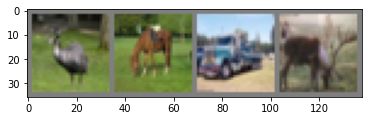

bird  horse truck deer 


In [7]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

We can now assert that images are of the right format, and also use the opportunity to give some names to the dimensions

In [8]:
images &nt // "(batch=4, channels=3, height=32, width =32)"
nt.dims

Updating batch to 4
Updating channels to 3
Updating height to 32
Updating width to 32


{'batch': 4, 'channels': 3, 'height': 32, 'width': 32}

## Defining a model with assertions

In [9]:
import torch.nn as nn
import torch.nn.functional as F

#From https://discuss.pytorch.org/t/utility-function-for-calculating-the-shape-of-a-conv-output/11173/5
def conv_output_shape(h_,w_, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_ + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((w_ + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        a,b = conv_output_shape(nt.height,nt.width,5)
        self.conv1 = nn.Conv2d(3, 6, 5) &nt // "batch,channels,width,height -> batch, channel1=6 ,conv1h=a, conv1w=b"
        poolh,poolw = conv_output_shape(nt.conv1h,nt.conv1w,2,2)
        self.pool = nn.MaxPool2d(2, 2) &nt // "batch, channel1, conv1h,conv1w -> batch, channel1,pool1h=poolh,pool1w=poolw"
        
        a,b = conv_output_shape(nt.pool1h,nt.pool1w,5)
        self.conv2 = nn.Conv2d(6, 16, 5) &nt // "batch, channel1, poolh,poolw -> batch, channel2=16, conv2h = a, conv2w=b"
        nt.pool2h,nt.pool2w = conv_output_shape(nt.conv2h,nt.conv2w,2,2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  &nt // "batch, channel2*pool2h*pool2w -> batch, 120"
        self.fc2 = nn.Linear(120, 84) &nt // "batch, 120 -> batch, 84"
        self.fc3 = nn.Linear(84, 10) &nt // "batch, 84 -> batch, 10"

    def forward(self, x):
        x &nt // "batch, channels, height, width"
        x = self.pool(F.relu(self.conv1(x))) &nt // "batch, channel1,pool1h,pool1w" 
        x = self.pool(F.relu(self.conv2(x))) &nt // "batch, channel2,pool2h,pool2w"
        x = torch.flatten(x, 1) &nt // "batch, channel2*pool2h*pool2w" # flatten all dimensions except batch 
        x = F.relu(self.fc1(x)) &nt // "batch, 120"
        x = F.relu(self.fc2(x)) &nt // "batch, 84"
        x = self.fc3(x) &nt // "batch, 10"
        return x


net = Net()
net(images)
nt.dims

Updating channel1 to 6
Updating conv1h to 28
Updating conv1w to 28
Updating pool1h to 14
Updating pool1w to 14
Updating channel2 to 16
Updating conv2h to 10
Updating conv2w to 10


{'batch': 4,
 'channel1': 6,
 'channel2': 16,
 'channels': 3,
 'conv1h': 28,
 'conv1w': 28,
 'conv2h': 10,
 'conv2w': 10,
 'height': 32,
 'pool1h': 14,
 'pool1w': 14,
 'pool2h': 5,
 'pool2w': 5,
 'width': 32}

We can supress the assertions by using `with skip_asserts():` in the code. We can also use `with skip_asserts(flag)` to skip the assertions if and only if the `flag` is True.

In [10]:
x = torch.randn(1, 3, 32, 32)
with skip_asserts():
    x &nt // "batch, channels, height, width+1"

In [11]:
try:
    x &nt // "batch, channels, height, width+1"
except AssertionError as e:
    print(e)

Dimension expression batch, channels, height, width+1 must have the same dimensions as the tensor ([[[[-3.3318e-01,  2.6058e-0.., got (4, 3, 32, 33) vs torch.Size([1, 3, 32, 32])


#### Training   

We can also train the network. For actual training, I suggest turning assertions off

In [12]:
import torch.optim as optim

def train(net):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')


In [13]:
net1 , net2 = Net(), Net()

Let's train with and without assertions to see the difference (this is on a CPU so quite slow)

In [14]:
%%time
train(net1)

[1,  2000] loss: 2.193
[1,  4000] loss: 1.869
[1,  6000] loss: 1.651
[1,  8000] loss: 1.557
[1, 10000] loss: 1.502
[1, 12000] loss: 1.461
[2,  2000] loss: 1.402
[2,  4000] loss: 1.377
[2,  6000] loss: 1.339
[2,  8000] loss: 1.308
[2, 10000] loss: 1.298
[2, 12000] loss: 1.265
Finished Training
CPU times: user 2min 39s, sys: 13.5 s, total: 2min 53s
Wall time: 3min 17s


In [15]:
%%time
with skip_asserts():
    train(net2)

[1,  2000] loss: 2.184
[1,  4000] loss: 1.855
[1,  6000] loss: 1.669
[1,  8000] loss: 1.584
[1, 10000] loss: 1.505
[1, 12000] loss: 1.461
[2,  2000] loss: 1.421
[2,  4000] loss: 1.395
[2,  6000] loss: 1.342
[2,  8000] loss: 1.356
[2, 10000] loss: 1.325
[2, 12000] loss: 1.297
Finished Training
CPU times: user 2min 18s, sys: 13.3 s, total: 2min 32s
Wall time: 2min 50s


We can compare this with the time to train a model with all assertions commented out

In [16]:
class Net_No_Assertions(nn.Module):
    def __init__(self):
        super().__init__()
        #a,b = conv_output_shape(nt.height,nt.width,5)
        self.conv1 = nn.Conv2d(3, 6, 5) # &nt // "batch,channels,width,height -> batch, channel1=6 ,conv1h=a, conv1w=b"
        #poolh,poolw = conv_output_shape(nt.conv1h,nt.conv1w,2,2)
        self.pool = nn.MaxPool2d(2, 2) #&nt // "batch, channel1, conv1h,conv1w -> batch, channel1,pool1h=poolh,pool1w=poolw"
        
        #a,b = conv_output_shape(nt.pool1h,nt.pool1w,5)
        self.conv2 = nn.Conv2d(6, 16, 5) #&nt // "batch, channel1, poolh,poolw -> batch, channel2=16, conv2h = a, conv2w=b"
        #nt.pool2h,nt.pool2w = conv_output_shape(nt.conv2h,nt.conv2w,2,2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # &nt // "batch, channel2*pool2h*pool2w -> batch, 120"
        self.fc2 = nn.Linear(120, 84) # &nt // "batch, 120 -> batch, 84"
        self.fc3 = nn.Linear(84, 10) # &nt // "batch, 84 -> batch, 10"

    def forward(self, x):
        x # &nt // "batch, channels, height, width"
        x = self.pool(F.relu(self.conv1(x))) #&nt // "batch, channel1,pool1h,pool1w" 
        x = self.pool(F.relu(self.conv2(x))) #&nt // "batch, channel2,pool2h,pool2w"
        x = torch.flatten(x, 1) #&nt // "batch, channel2*pool2h*pool2w" # flatten all dimensions except batch 
        x = F.relu(self.fc1(x)) #&nt // "batch, 120"
        x = F.relu(self.fc2(x)) #&nt // "batch, 84"
        x = self.fc3(x) #&nt // "batch, 10"
        return x


In [17]:
%%time
train(Net_No_Assertions())

[1,  2000] loss: 2.215
[1,  4000] loss: 1.861
[1,  6000] loss: 1.669
[1,  8000] loss: 1.573
[1, 10000] loss: 1.485
[1, 12000] loss: 1.458
[2,  2000] loss: 1.376
[2,  4000] loss: 1.352
[2,  6000] loss: 1.339
[2,  8000] loss: 1.310
[2, 10000] loss: 1.279
[2, 12000] loss: 1.256
Finished Training
CPU times: user 1min 55s, sys: 10.1 s, total: 2min 5s
Wall time: 2min 25s


We see that there is some benefit to actually commenting out assertions in the `forward` function. Should see if there are ways to optimize things more. (Should also run more tests of multiple runs, various models, GPU vs CPU, etc..)

### Testing

For fun we can also test the network

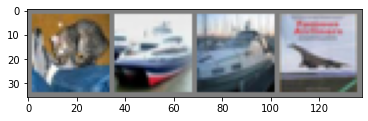

GroundTruth:  cat   ship  ship  plane


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [19]:
outputs = net1(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [20]:
# Compare with untrained network
outputs = Net()(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  plane plane plane plane
